# Imports de librerías

In [85]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

sns.set_context('talk')
sns.set_style('darkgrid')

# Dataset

## Carga de los datos

In [5]:
df = pd.read_csv("airbnb.csv")

## Breve análisis del dataset

Tamaño del dataset.

In [6]:
df.shape

(17608, 74)

Nombre de todas las columnas.

In [7]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Visualización de todas las características de una muestra.

In [8]:
pd.set_option('display.max_rows', None)
df.iloc[0,:]

id                                                                                          11547
listing_url                                                    https://www.airbnb.com/rooms/11547
scrape_id                                                                          20200919153121
last_scraped                                                                           2020-09-21
name                                                                         My home at the beach
description                                     Sun, joy, relax, quality, beach & peace.<br />...
neighborhood_overview                                                                         NaN
picture_url                                     https://a0.muscache.com/pictures/494126/8c151b...
host_id                                                                                     42942
host_url                                                  https://www.airbnb.com/users/show/42942
host_name           

# Primera limpieza de datos

En este punto, se realizará una primera limpieza de los datos eliminando las características que se sabe con certeza que no sirven para el modelo para poder realizar el análisis descriptivo de mejor forma.
Se eliminarán aquellas características que son descriptivas/subjetivas las cuales no aportan ningun valor. Se han eliminado las características del tipo:

* Identificadores cuyos valores asociados no se conocen
* Descripciones subjetivas de las casas o lugares
* Links de las casas o a imágenes de la casa
* Información de los hosts de las casas como nombres o información sobre ellos
* Información sobre el scraping realizado

Por ello, se ha creado un nuevo dataframe con las siguientes características.

In [9]:
df_firstcleaning = df[[
       'host_id',
        'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
        'price']].copy()

df_firstcleaning.shape

(17608, 60)

A continuación, se comprueba el número de valores nulos por características. Si el número de valores nulos es igual o muy próximo al número de muestras dicha característica será eliminada ya que no aportará ningún tipo de información.

In [446]:
df_firstcleaning.isnull().sum()

host_id                                             0
host_since                                          2
host_location                                      36
host_response_time                               1746
host_response_rate                               1746
host_acceptance_rate                             1510
host_is_superhost                                   2
host_neighbourhood                              17244
host_listings_count                                 2
host_total_listings_count                           2
host_verifications                                  0
host_has_profile_pic                                2
host_identity_verified                              2
neighbourhood                                    9395
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    17608
latitude                                            0
longitude                                           0
property_type               

In [10]:
df_firstcleaning = df_firstcleaning.drop(['host_neighbourhood','neighbourhood_group_cleansed',
                                          'bathrooms','calendar_updated'], axis=1)

Las columnas que se han eliminado hasta el momento son las siguientes:

In [11]:
removed_columns = []
for x in df.columns:
    if x not in df_firstcleaning:
        removed_columns.append(x)
        
removed_columns       

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'host_name',
 'host_about',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'calendar_updated',
 'calendar_last_scraped']

Finalmente, se eliminará el símbolo del dolar $ de los valores de la columna "price", que es el target, y se convertirá de string a valor numérico.

In [12]:
df_firstcleaning['price'] = df_firstcleaning['price'].apply(lambda x: x.split("$")[1])
df_firstcleaning['price'] = df_firstcleaning['price'].apply(lambda x: x.replace(",",""))
df_firstcleaning['price'] = df_firstcleaning['price'].astype(float)

# Análisis de la característica price (target)

<AxesSubplot:xlabel='price', ylabel='Count'>

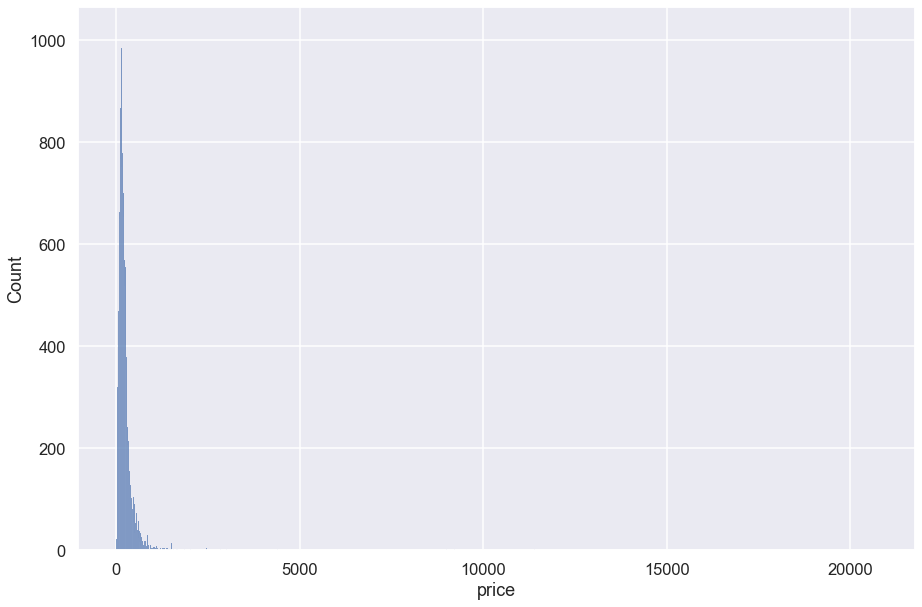

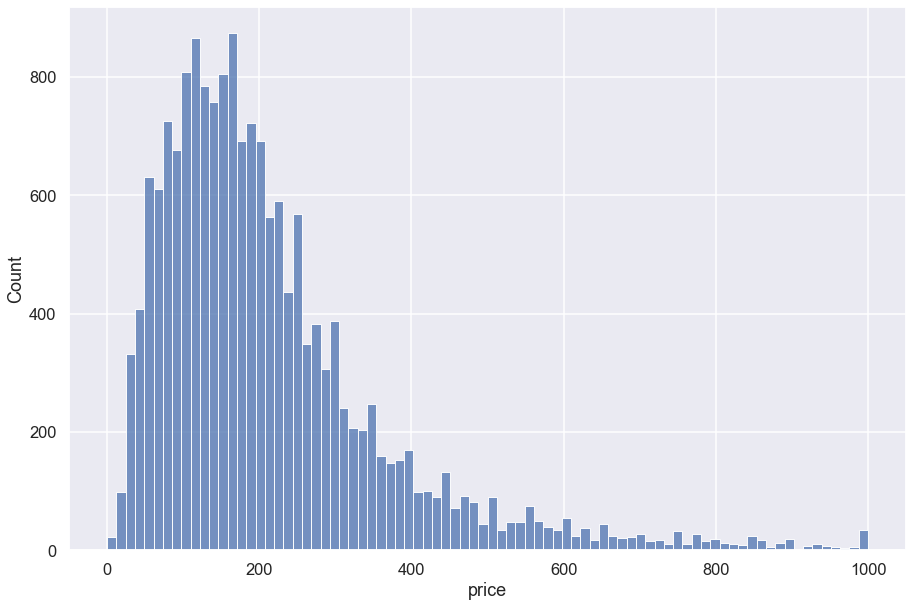

In [450]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(ax=ax, x=df_firstcleaning.price)

fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(ax=ax, x=df_firstcleaning['price'][df_firstcleaning['price'] <= 1000])



<AxesSubplot:xlabel='price'>

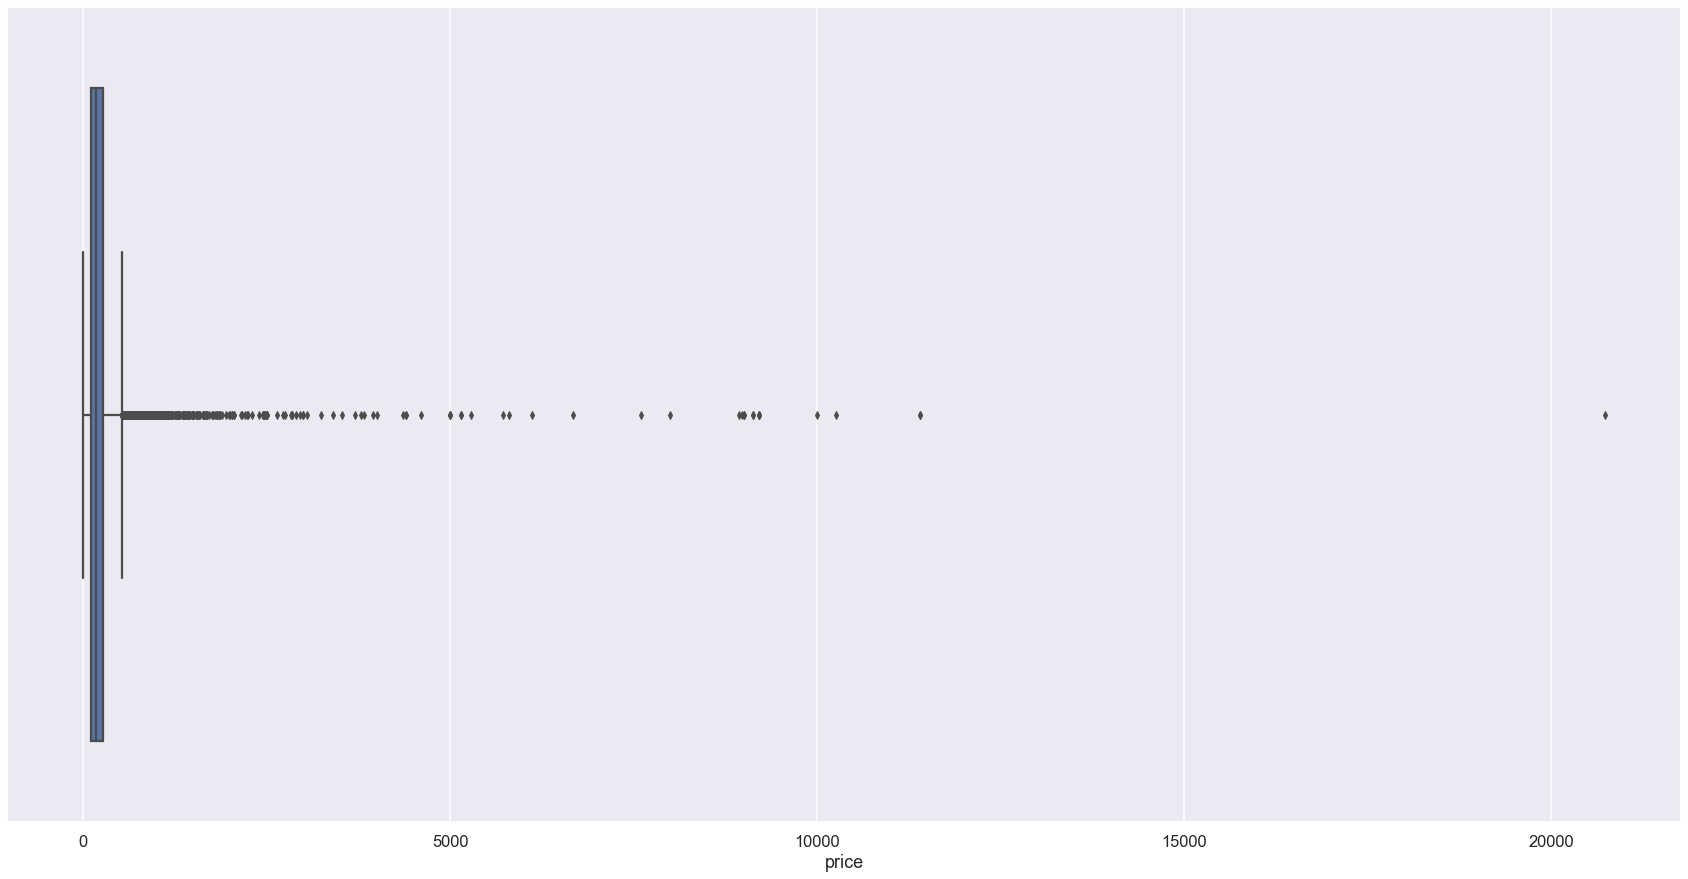

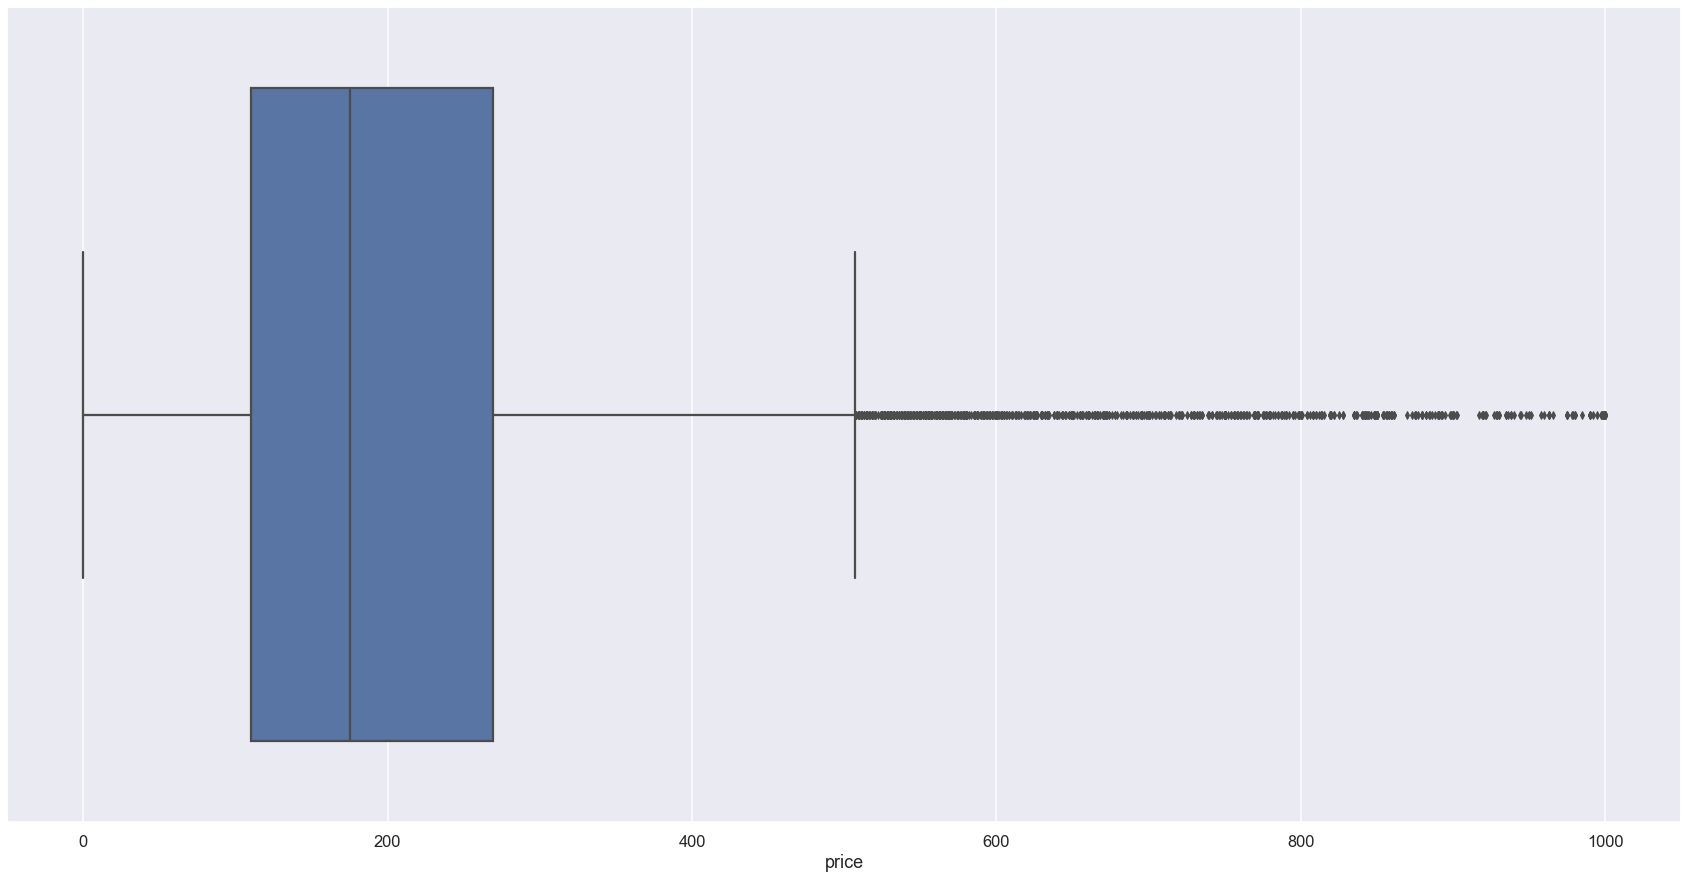

In [451]:
fig, ax = plt.subplots(1, 1, figsize=(30, 15))
sns.boxplot(data=df_firstcleaning, x='price', ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
sns.boxplot(data=df_firstcleaning[df_firstcleaning['price'] <= 1000], x='price', ax=ax)

# Outliers

Debido a que el dataset contiene varias muestras que son outliers y se encuentran fuera del rango habitual, se eliminarán todas aquellas muestras con un precio superior a 445, valor que se ha podido observar como rango máximo en el boxplot.

In [21]:
df_firstcleaning = df_firstcleaning[df_firstcleaning['price'] <= 445]

In [22]:
# Número de muestras iniciales
df.shape[0] 

17608

In [23]:
# Número de muestras tras la reducción
df_firstcleaning.shape[0] 

15954

In [24]:
# Número de muestras eliminadas
df.shape[0] - df_firstcleaning.shape[0]

1654

# Anáslisis exploratorio de los datos

Visualizamos cuantos valores diferentes se pueden dar en cada característica para evitar que una característica tenga tantos posibles valores como muestras o que todas las muestras tengan el mismo valor siendo en ambos casos información irrelevante.

In [458]:
for col in df_firstcleaning:
    print(col, len(df_firstcleaning[col].unique()))

host_id 5290
host_since 2487
host_location 792
host_response_time 5
host_response_rate 50
host_acceptance_rate 83
host_is_superhost 3
host_listings_count 135
host_total_listings_count 135
host_verifications 209
host_has_profile_pic 3
host_identity_verified 3
neighbourhood 984
neighbourhood_cleansed 53
latitude 13710
longitude 14115
property_type 74
room_type 4
accommodates 17
bathrooms_text 37
bedrooms 17
beds 26
amenities 14486
minimum_nights 40
maximum_nights 142
minimum_minimum_nights 42
maximum_minimum_nights 51
minimum_maximum_nights 128
maximum_maximum_nights 123
minimum_nights_avg_ntm 190
maximum_nights_avg_ntm 1164
has_availability 2
availability_30 31
availability_60 61
availability_90 91
availability_365 366
number_of_reviews 234
number_of_reviews_ltm 56
number_of_reviews_l30d 12
first_review 2028
last_review 1052
review_scores_rating 46
review_scores_accuracy 10
review_scores_cleanliness 10
review_scores_checkin 9
review_scores_communication 10
review_scores_location 9
revie

Visto esto, se puede comprobar como tanto host_id, latitude, longitude y amenities tienen unos valores diferentes para casi cada muestra por lo que no aportan información relevante. Sin embargo, destacar que la variable amenities está formado por una array con diferentes servicios por lo que un cambio en el orden de estos puede ser consecuencia de esta gran cantidad de diferentes valores para dicha característica.

A continuación, analizaremos cada una de las características para conocer si están relacionadas con el precio o no aportan ninguna información.

## Grupo características anfitrión

En primer lugar, analizaremos si las características propias del anfitrión (host) están relacionadas con el precio. A primera vista se puede decir que estas variables no afectan en el precio de una casa de forma directa ya que por mucho que el anfitrión cambie, el precio seguirá siendo mas o menos el mismo. 

Las características que analizaremos en este grupo son las siguientes (junto con el target que es el precio):

In [459]:
df_host = df_firstcleaning[[
    'host_id', 'host_since', 'host_location',
    'host_response_time', 'host_response_rate', 
     'host_acceptance_rate','host_is_superhost', 
    'host_listings_count','host_total_listings_count', 
     'host_verifications', 'host_has_profile_pic', 
    'host_identity_verified', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 
    'calculated_host_listings_count_shared_rooms',
    'price']].copy()

Visualizaremos algunos posibles valores de cada una de las características.

In [460]:
for x in df_host:
    print(x, df_host[x].unique()[0:5])

host_id [ 42942 529151 549192 551974 643065]
host_since ['2009-10-02' '2011-04-23' '2011-05-01' '2011-05-02' '2011-05-30']
host_location [' Balearic Islands, Spain' 'Mallorca' 'Ariany, Balearic Islands, Spain'
 'Palma de Mallorca, Balearic Islands, Spain'
 'Inca, Balearic Islands, Spain']
host_response_time ['within an hour' nan 'within a few hours' 'within a day'
 'a few days or more']
host_response_rate ['100%' nan '86%' '90%' '0%']
host_acceptance_rate ['96%' '100%' '83%' nan '29%']
host_is_superhost ['f' 't' nan]
host_listings_count [0. 1. 2. 3. 5.]
host_total_listings_count [0. 1. 2. 3. 5.]
host_verifications ["['email', 'phone', 'reviews', 'jumio', 'government_id']"
 "['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id']"
 "['email', 'phone', 'facebook', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']"
 "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']"
 "['email'

Con los posibles valores que se establecen, está claro que el host_id, por el motivo mencionado anteriormente, no proporciona ninguna información sobre el precio. Y del mismo modo, tampoco las características host_since, host_location y host_verifications. Estas ya no serán ni evaluadas, se descartan directamente.

A continuación se visualizará si hay alguna relación entre el resto de características y el precio.

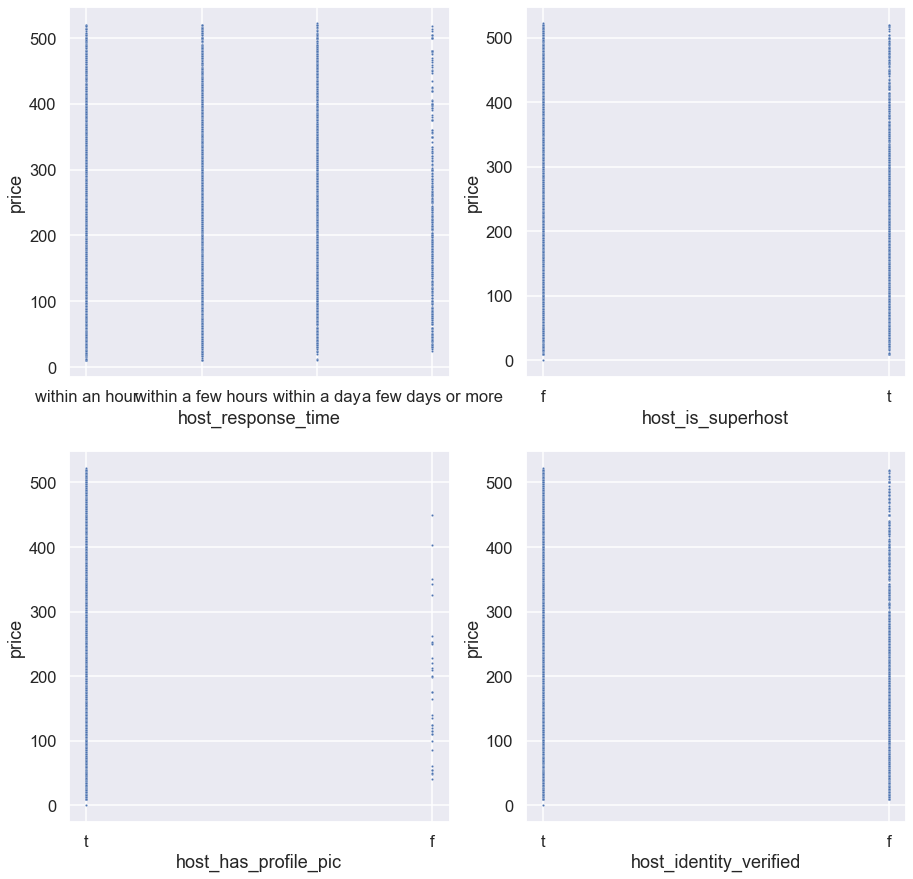

In [461]:
df_host1 = df_host[[
    'host_response_time','host_is_superhost',
     'host_has_profile_pic', 'host_identity_verified', 
    'price']]


variables = df_host1.columns[0:-1]
columns = 2
rows = int(len(variables) / 2)
fig, ax = plt.subplots(rows, columns, figsize=(15, 15))
for var, subplot in zip(variables, ax.flatten()):
    sns.scatterplot(data=df_host1, x=var, y='price', ax=subplot, s=5)

Como se puede comprobar con estos gráficos, no existe ninguna relación entre el valor de estas primeras características que nos permita estabelecer una relación con un valor inferior o superior del precio.

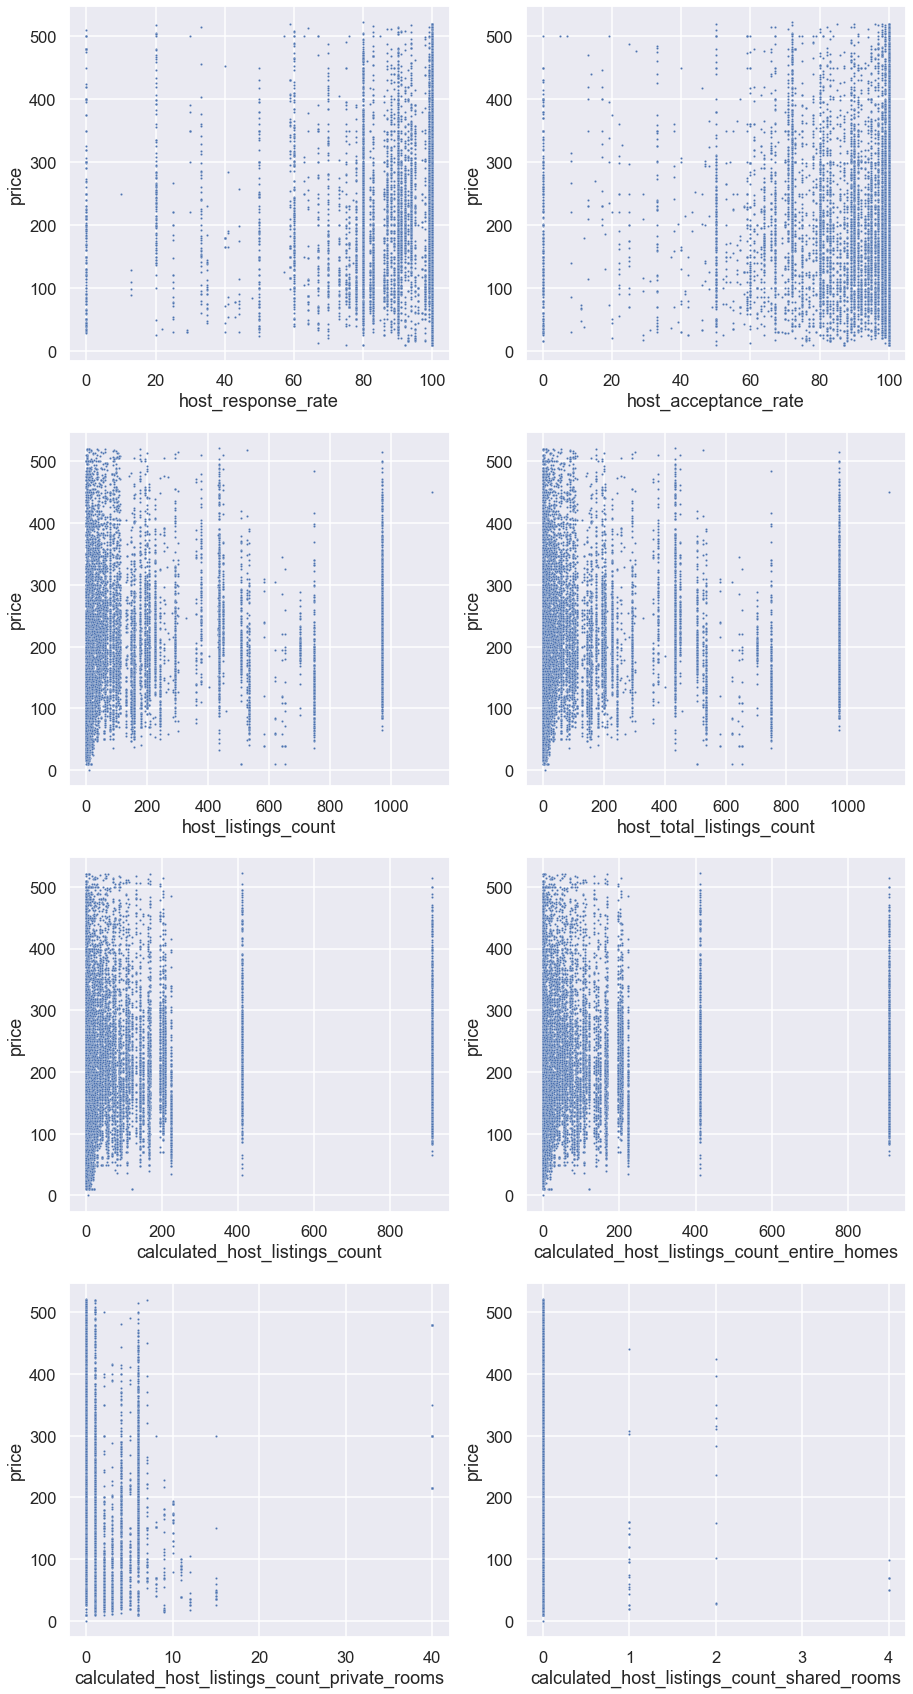

In [462]:
df_host2 = df_host[[
    'host_response_rate', 
     'host_acceptance_rate','host_listings_count',
    'host_total_listings_count', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'price']].copy()

# Formateamos los datos de los valores de las siguientes características para
# que sean número y pueden analizarse correctamente.
df_host2['host_response_rate'] = df_host2['host_response_rate'].astype(str)
df_host2['host_acceptance_rate'] = df_host2['host_acceptance_rate'].astype(str)
df_host2['host_response_rate'] = df_host2['host_response_rate'].apply(lambda x: float(x.split("%")[0]))
df_host2['host_acceptance_rate'] = df_host2['host_acceptance_rate'].apply(lambda x: float(x.split("%")[0]))

df_host2  = df_host2[df_host2['price'] < 1000]

variables = df_host2.columns[0:-1]
columns = 2
rows = int(len(variables) / 2)
fig, ax = plt.subplots(rows, columns, figsize=(15, 30))
for var, subplot in zip(variables, ax.flatten()):
    sns.scatterplot(data=df_host2, x=var, y='price', ax=subplot, s=5)

Con todo este grupo de características analizadas que implican al host, se pueden visualizar como ninguna de ellas tiene una relación con la subida ni bajada del precio de una casa. Por ello, ninguna de estas características se utilizarán.

## Grupo características noches

En siguiente grupo de características serán aquellas relacionadas con el número de noches. En cuanto a estas características no se pueden generalizar ya que cada cliente tiene un número concreto de noches que pasará en la casa, además, que una casa tenga un mínimo de 3 o 5 noches no afectará de forma notable al precio por noche de dicha casa. Por lo tanto, estas características no aportan ninguna información relevante.

In [463]:
df_nights = df_firstcleaning[[
        'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'price']]

df_nights.describe()

,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,price
count,16448.000,16448.000,16448.000,16448.000,16448.000,16448.000,16448.000,16448.000,16448.000
mean,4.361,861.214,4.533,6.106,837.751,924.941,5.177,877.200,187.924
std,12.992,453.696,13.729,16.182,473.202,410.258,13.848,429.747,107.617
min,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000
25%,1.000,365.000,2.000,3.000,365.000,1125.000,3.000,730.000,105.000
50%,4.000,1125.000,4.000,5.000,1125.000,1125.000,4.900,1125.000,169.000
75%,6.000,1125.000,5.000,7.000,1125.000,1125.000,6.200,1125.000,250.000
max,1124.000,3500.000,1124.000,1124.000,3500.000,3500.000,1124.000,3500.000,522.000


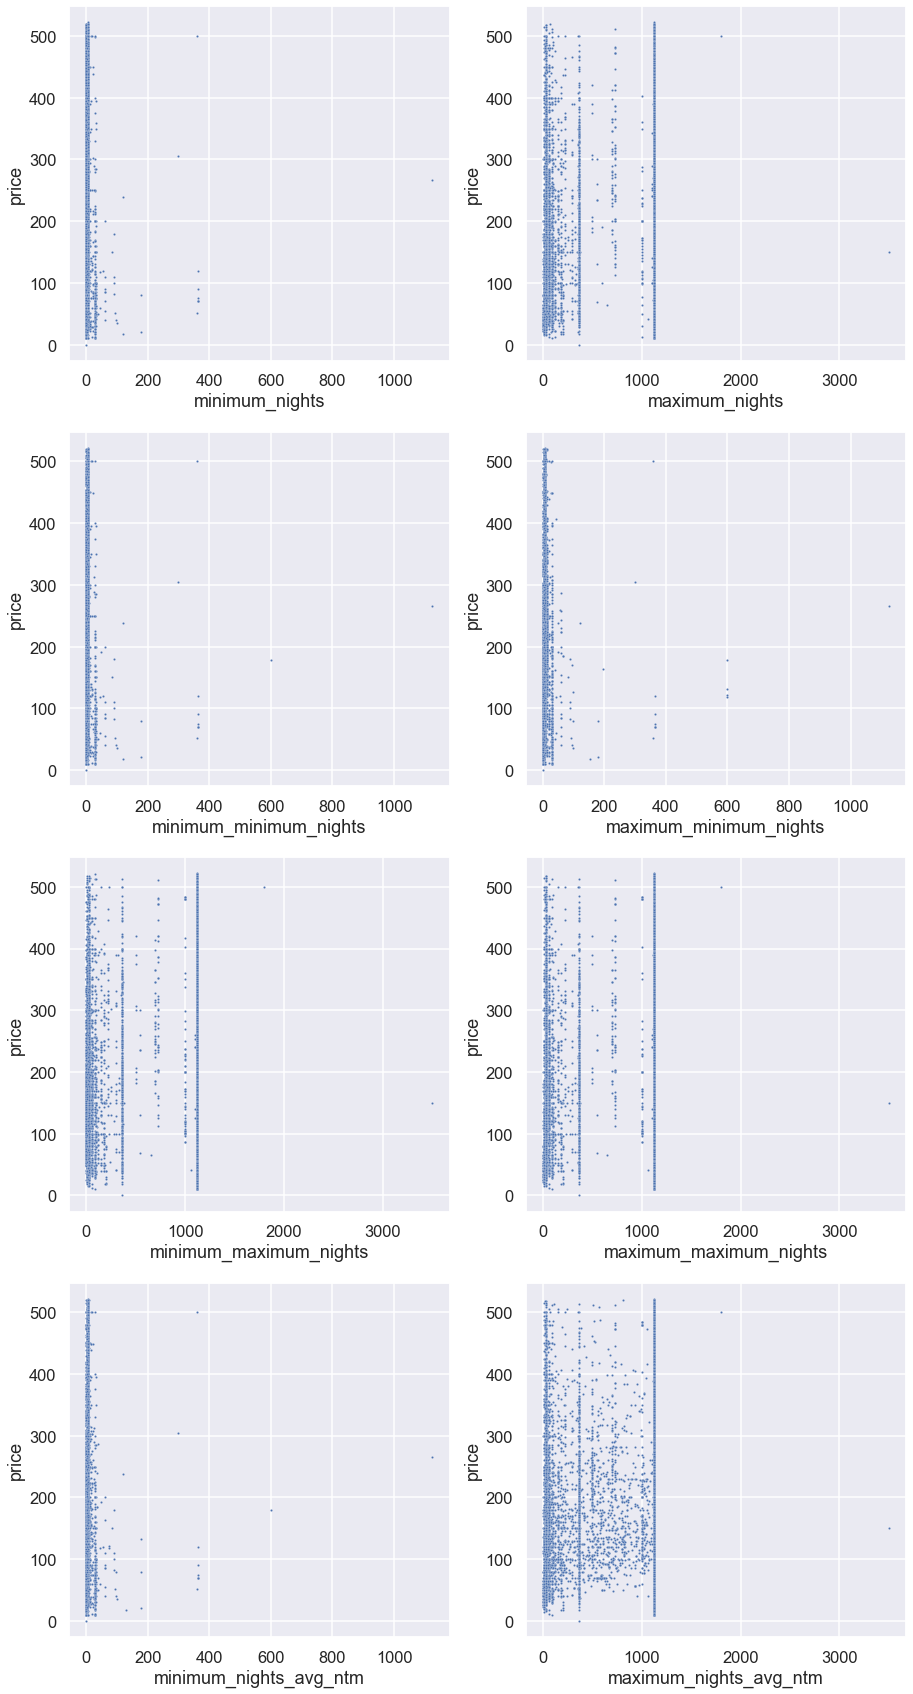

In [464]:
variables = df_nights.columns[0:-1]
columns = 2
rows = int(len(variables) / 2)
fig, ax = plt.subplots(rows, columns, figsize=(15, 30))
for var, subplot in zip(variables, ax.flatten()):
    sns.scatterplot(data=df_nights, x=var, y='price', ax=subplot, s=5)

## Grupo características disponibilidad

In [465]:
df_av = df_firstcleaning[[
       'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365']]

Este grupo de características no es necesario comprobar si existe relación ya que está claro que la disponibilidad no influye de ninguna manera.

## Grupo características review

A continuación, se analizarán todas aquellas características relacionadas con las review. Estas son las siguientes:

In [466]:
df_review = df_firstcleaning[[
         'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','reviews_per_month',
        'price']]

Además, mencionar que las características first_review y last_review han sido descartadas ya que no aportan ningún valor.

In [467]:
for x in df_review:
    print(x, df_review[x].unique()[0:10])

number_of_reviews [103  30  14   9   0 151 268  62 100 159]
number_of_reviews_ltm [ 8 13  0  1 22  3 18 15  7  2]
number_of_reviews_l30d [ 2  0  1  4  3  5  6  7  8 11]
review_scores_rating [ 96. 100.  97.  98.  nan  94.  95.  90.  88.  91.]
review_scores_accuracy [10. nan  9.  8.  6.  7.  2.  4.  5.  3.]
review_scores_cleanliness [ 9. 10. nan  6.  5.  8.  7.  2.  4.  3.]
review_scores_checkin [10. nan  9.  6.  8.  4.  7.  2.  5.]
review_scores_communication [10. nan  9.  2.  7.  8.  6.  4.  3.  5.]
review_scores_location [10.  9. nan  8.  7.  6.  2.  4.  5.]
review_scores_value [10.  9. nan  8.  6.  7.  2.  4.  3.  5.]
reviews_per_month [0.93 1.47 0.14 0.09  nan 1.37 2.44 0.56 0.9  1.32]
price [ 89. 175. 140. 200. 110.  75.  90. 235.  45.  18.]


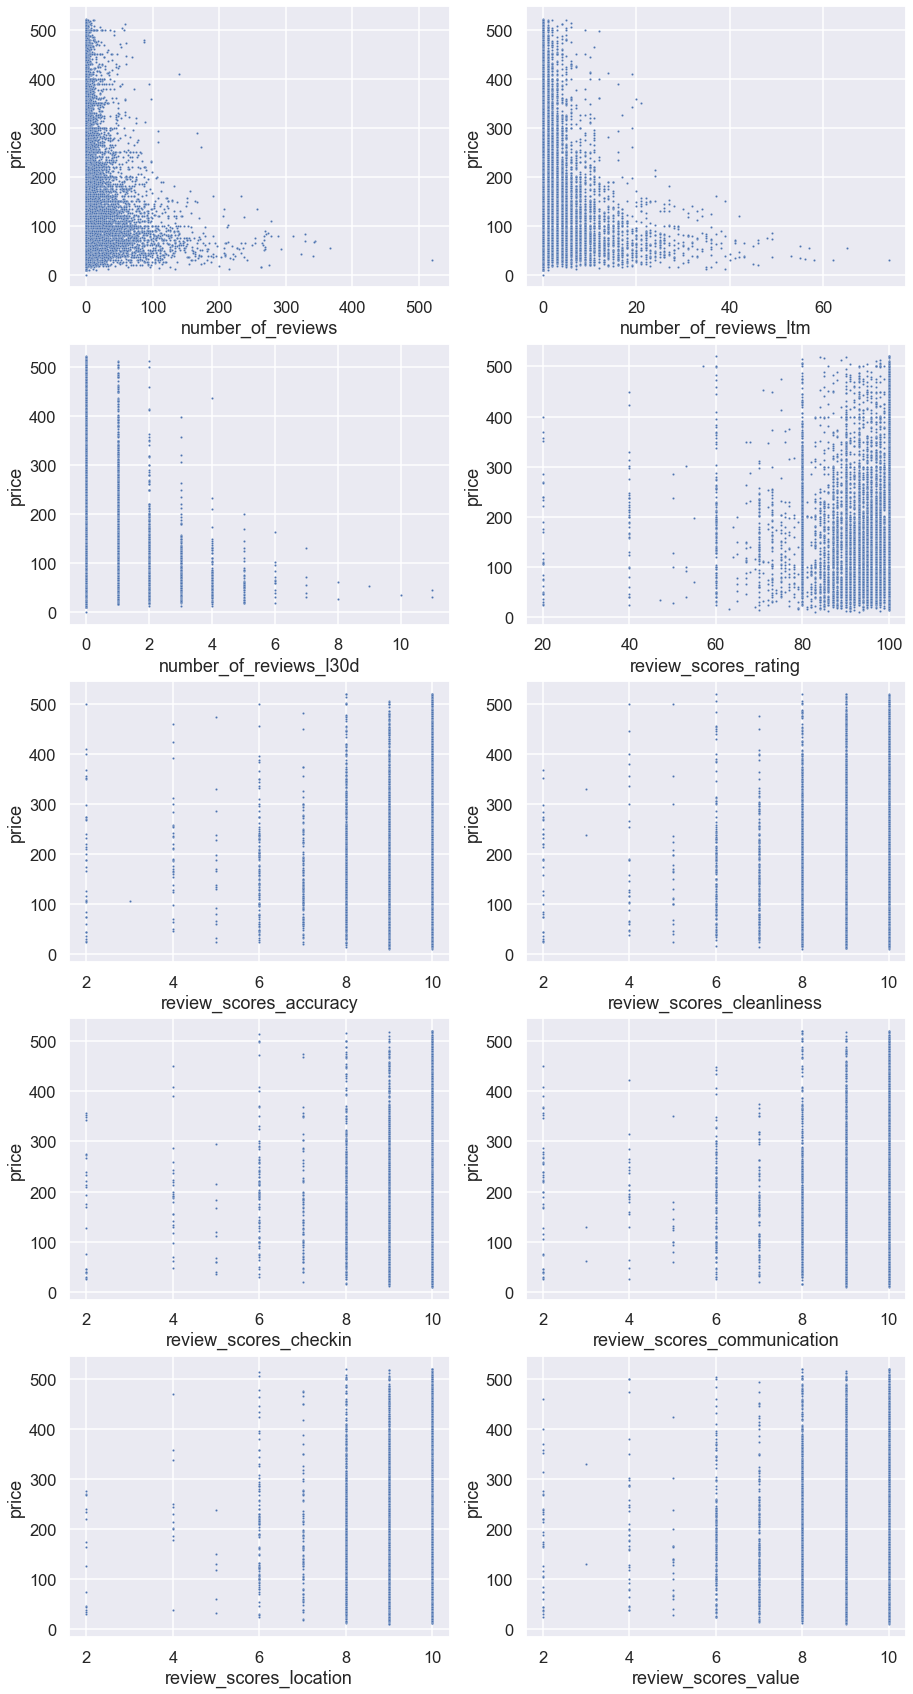

In [468]:
variables = df_review.columns[0:-1]
columns = 2
rows = int(len(variables) / 2)
fig, ax = plt.subplots(rows, columns, figsize=(15, 30))
for var, subplot in zip(variables, ax.flatten()):
    sns.scatterplot(data=df_review, x=var, y='price', ax=subplot, s=5)

En este grupo de características, se puede comprobar como las características relacionadas con el número de reviews no afecta al precio. Sin embargo, la puntuación de las reviews si establecen una relación en el precio donde aquellas casas con mayor precio suelen tener unas puntuaciones entre 8 y 10.

## Último grupo de características

In [137]:
df_features = df_firstcleaning[[
        'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'license', 'instant_bookable',
        'price']]

Mostramos algunos posibles valores de cada una de estas variables.

In [470]:
for x in df_features:
    print(x, df_features[x].unique()[0:5])

neighbourhood [nan 'Maria de la Salut, Balearic Islands, Spain'
 'Palma de Mallorca, PM, Spain'
 'Palma de Mallorca, Balearic Islands, Spain'
 'Sa Pobla, Balearic Islands, Spain']
neighbourhood_cleansed ['Calvià' 'Santa Margalida' 'Maria de la Salut'
 'Sant Llorenç des Cardassar' 'Palma de Mallorca']
latitude [39.51888 39.76347 39.66044 39.616   39.56478]
longitude [2.48182 3.16255 3.07165 3.30121 2.60333]
property_type ['Entire apartment' 'Entire house' 'Entire townhouse' 'Entire villa'
 'Private room in apartment']
room_type ['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']
accommodates [2 8 6 4 3]
bathrooms_text ['1 bath' '3 baths' '2 baths' '1 private bath' '0 baths']
bedrooms [ 1.  4.  3.  2. nan]
beds [1. 7. 4. 2. 0.]
amenities ['["Oven", "Wifi", "Coffee maker", "Dishes and silverware", "Essentials", "Kitchen", "TV", "Cooking basics", "Refrigerator", "Shampoo", "Microwave", "Pool", "Beachfront", "Free parking on premises", "Free street parking", "Air conditioning", "H

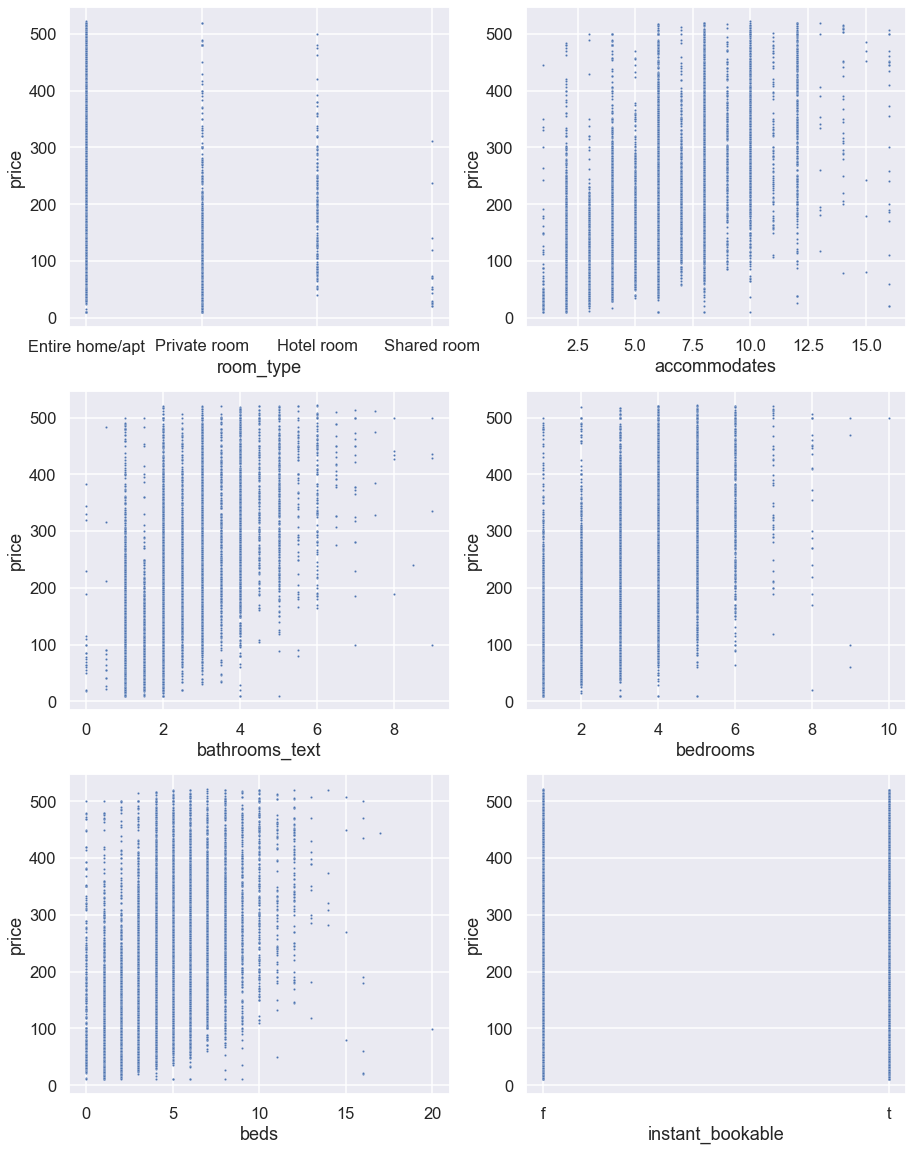

In [471]:
df_features1 = df_features[[
       'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'instant_bookable',
        'price']].copy()

df_features1  = df_features1[df_features1['price'] < 10000]
df_features1  = df_features1[df_features1['beds'] <= 20]
df_features1  = df_features1[df_features1['bedrooms'] <= 10]

df_features1 = df_features1.replace({'bathrooms_text': "Shared half-bath"}, "0.5 bath")
df_features1 = df_features1.replace({'bathrooms_text': "Half-bath"}, "0.5 bath")
df_features1 = df_features1.replace({'bathrooms_text': "Private half-bath"}, "0.5 bath")
df_features1['bathrooms_text'] = df_features1['bathrooms_text'].apply(lambda x: str(x).split(" ")[0])
df_features1['bathrooms_text'] = df_features1['bathrooms_text'].astype(float)

df_features1  = df_features1[df_features1['bathrooms_text'] <= 10]

variables = df_features1.columns[0:-1]
columns = 2
rows = int(len(variables) / 2)
fig, ax = plt.subplots(rows, columns, figsize=(15, 20))
for var, subplot in zip(variables, ax.flatten()):
    sns.scatterplot(data=df_features1, x=var, y='price', ax=subplot, s=5)

Con estas gráficas se puede ver como las características accomodates, bathrooms, bedrooms y beds están relacionadas con el precio donde a mayor número de estas el precio es superior. Además la característica room_type también permite ofrecer relación con el precio donde según el posible valor (entre los 4 posibles) influirá en el precio. En cambio, la característica instant_bookable no tiene ninguna relación.

A continuación, se visualizará si el municipio (neighbourhood_cleansed) y el tipo de propiedad (property_type) pueden tener alguna relación con el precio.

<AxesSubplot:xlabel='price', ylabel='neighbourhood_cleansed'>

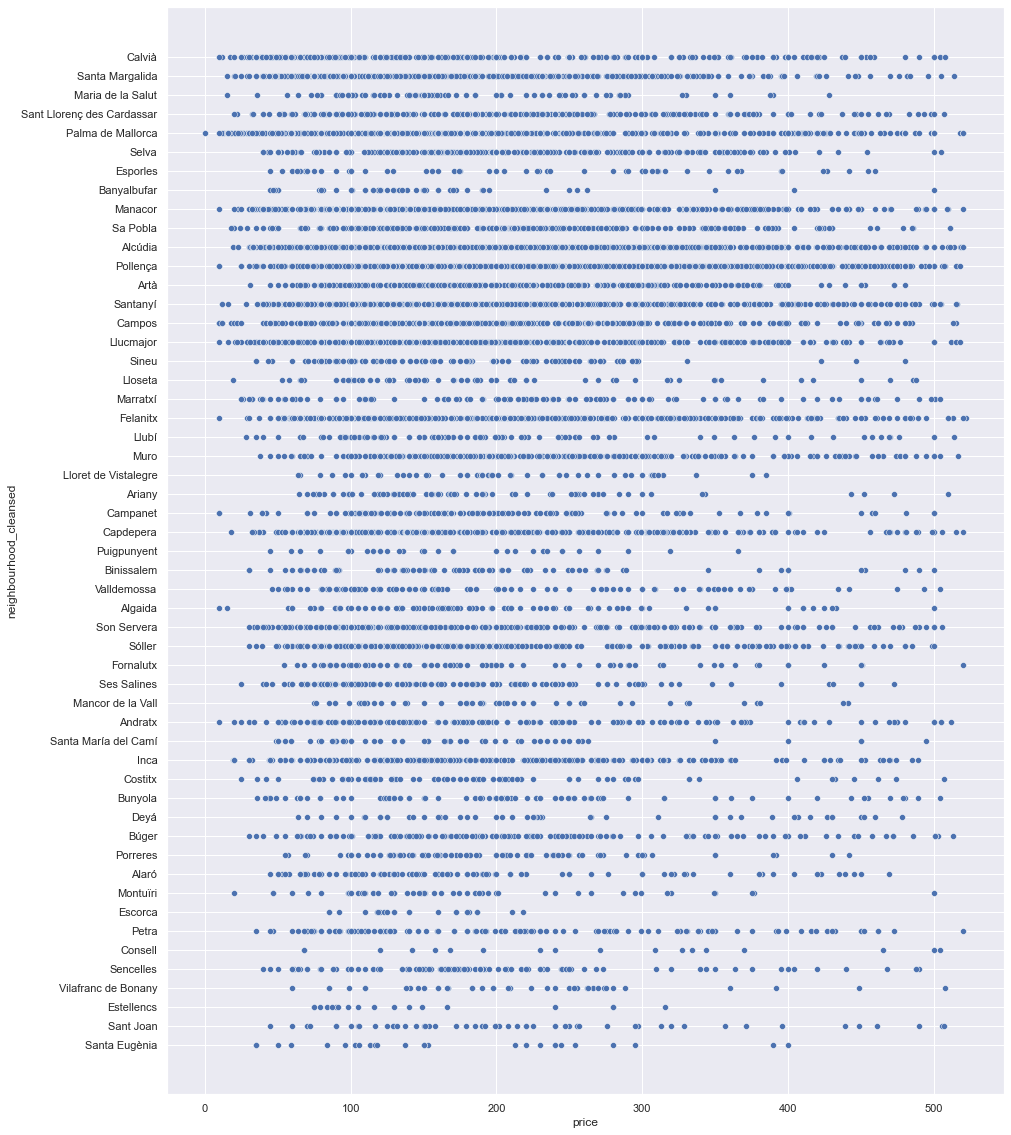

In [472]:
sns.set(rc={'figure.figsize':(15,20)})
sns.scatterplot(data=df_features, y="neighbourhood_cleansed", x="price")  

<AxesSubplot:xlabel='price', ylabel='property_type'>

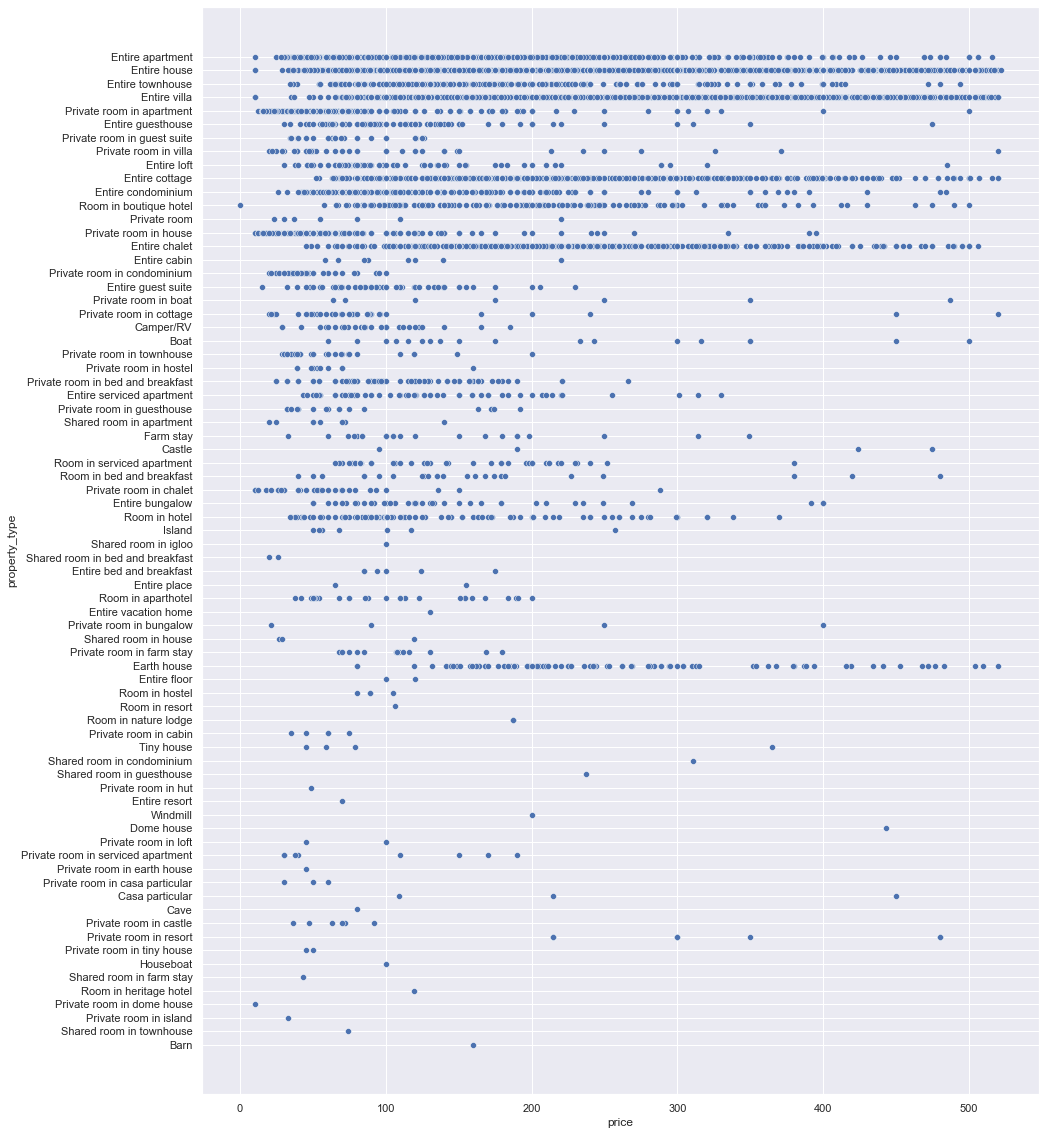

In [473]:
sns.set(rc={'figure.figsize':(15,20)})
sns.scatterplot(data=df_features, y="property_type", x="price")  

Con las dos gráficas anteriores, se puede ver como tanto el tipo de propiedad (property_type) como el municipio (neighbourhood_cleansed) sí ofrecen un precio inferior o superior según su posible valor.

Y finalmente, comprobaremos si el tener una licencia hace que el precio sea superior. La característica license está formada por un valor string con el nombre de la licencia que se tiene, en este caso, se asignará un 0 si no tienen licencia o un 1 si sí la tiene.

<AxesSubplot:ylabel='price'>

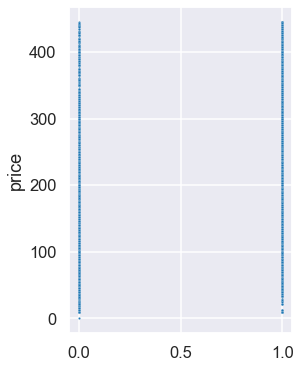

In [138]:
l=[]
for x in df_features["license"]:
    if str(x) == "nan":
        l.append(0)
    else:
        l.append(1)

fig, ax = plt.subplots(1, 1, figsize=(4, 6))
sns.scatterplot( y=df_features["price"], x=l, ax=ax, s=5)  

Como se puede apreciar, la licencia no hace que el precio sea superior.

# Segunda limpieza de los datos

Una vez explorado las características, eliminaremos aquellas que no tiene relación con el precio siguiendo el análisis de la sección anterior. El dataset llamado df_secondcleaning está compuesto solo por aquellas características que se utilizarán para el problema. Sin embargo, todavía queda terminar con la limpieza del dataset.

In [39]:
df_secondcleaning = df_firstcleaning[[
        'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 
       'price']].copy()


In [40]:
df_secondcleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15954 entries, 0 to 17607
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighbourhood_cleansed       15954 non-null  object 
 1   property_type                15954 non-null  object 
 2   room_type                    15954 non-null  object 
 3   accommodates                 15954 non-null  int64  
 4   bathrooms_text               15946 non-null  object 
 5   bedrooms                     15690 non-null  float64
 6   beds                         15872 non-null  float64
 7   amenities                    15954 non-null  object 
 8   review_scores_rating         10263 non-null  float64
 9   review_scores_accuracy       10260 non-null  float64
 10  review_scores_cleanliness    10262 non-null  float64
 11  review_scores_checkin        10260 non-null  float64
 12  review_scores_communication  10260 non-null  float64
 13  review_scores_lo

## Formateo de características

Seguidamente, se realizará un formateo de aquellas características cuyas formas de expresarse no son las adecuadas para el entrenamiento.

La variable bathrooms_text ofrece la información de los baños, sin embargo, se trata de un string incluso hay valores que indican el número de baños de forma escrita no númerica. Por ello, será necesario transformar los siguientes posibles valores en valores númericos.

In [41]:
df_secondcleaning.bathrooms_text.unique()

array(['1 bath', '3 baths', '2 baths', '1 private bath', '0 baths',
       '1.5 baths', '2 shared baths', '4.5 baths', '2.5 baths', '4 baths',
       '5 baths', 'Shared half-bath', '1.5 shared baths', '1 shared bath',
       '3.5 baths', nan, '6 baths', '5.5 baths', '4 shared baths',
       '8 baths', '7 baths', '0 shared baths', '2.5 shared baths',
       '6.5 baths', 'Half-bath', '3 shared baths', '3.5 shared baths',
       '9 baths', '11 baths', '12.5 baths', '32 baths',
       'Private half-bath', '13 shared baths', '10 baths', '7.5 baths',
       '8.5 baths', '13 baths'], dtype=object)

In [42]:
df_secondcleaning = df_secondcleaning.replace({'bathrooms_text': "Shared half-bath"}, "0.5 bath")
df_secondcleaning = df_secondcleaning.replace({'bathrooms_text': "Half-bath"}, "0.5 bath")
df_secondcleaning = df_secondcleaning.replace({'bathrooms_text': "Private half-bath"}, "0.5 bath")
df_secondcleaning['bathrooms_text'] = df_secondcleaning['bathrooms_text'].apply(lambda x: float(str(x).split(" ")[0]))

También se tratará la característica de las amenities. Su valor es un array con todos los servicios que tiene pero no está en formato array sino que está en formato string por lo que será necesario tratarlo. Además, al estar los servicios en diferente orden según la muestra será necesario realizar una tabla donde se indique en cada muestra si tienen o no dicho servicio.

In [43]:
services = []
for element in df_secondcleaning.amenities.tolist():
    s = element[2:-2].split(", ")
    for x in s:
        if x != "":
            value = x.replace('"','')
            if value not in services:
                services.append(value)

amenities_list = np.zeros(shape=(len(df_secondcleaning), len(services)))
amenities_list = pd.DataFrame(amenities_list, columns=services)

i = 0
for element in df_secondcleaning.amenities.tolist():
    s = element[2:-2].split(", ")
    for x in s:
        if x != "":
            value = x.replace('"','')
            amenities_list.iloc[i][value] = 1
    i+=1
    
amenities_list = amenities_list.astype(int)
amenities_list.head()

,Oven,Wifi,Coffee maker,Dishes and silverware,Essentials,Kitchen,TV,Cooking basics,Refrigerator,Shampoo,...,Slippers,Onsite bar \u2014 Beatnik,52\ HDTV,Airport shuttle,Bluetooth speaker,Laundry services,Beach,House bikes,Free wifi,Minibar
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Una vez se tiene la tabla con los servicios, se ofrecerá para cada muestra el número de servicios diferentes que ofrece.

In [44]:
i = 0
for index,x in df_secondcleaning.iterrows():
    value = sum(amenities_list.iloc[i,:])
    df_secondcleaning.loc[index,"amenities"] = value
    i +=1

Las variables neighbourhood_cleansed, property_type y room_type de tipo categórico será necesario realizar un encoding de las mismas. Por ello, se realizará un One Hot Encoding para poder interpretar las tres características. Añadir, que se valoró la opción de realizar el encoding de las características por separado, sin embargo, la realización de forma conjunta permitía obtener unos mejores resultados.

In [45]:
ohe = preprocessing.OneHotEncoder()
df_object_types = df_secondcleaning.select_dtypes('object')
ohe.fit(df_object_types)
codes = ohe.transform(df_object_types).toarray()

Construcción del dataset

In [67]:
dataset = df_secondcleaning[[
        'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].copy()
dataset = pd.concat([dataset, pd.DataFrame(codes).astype(int).set_index(dataset.index), df_secondcleaning["price"]], axis=1)

In [68]:
dataset.head()

,accommodates,bathrooms_text,bedrooms,beds,amenities,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,184,185,186,187,188,189,190,191,192,price
0,2,1.0,1.0,1.0,23,96.0,10.0,9.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,89.0
1,8,3.0,4.0,7.0,20,100.0,10.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,175.0
2,6,2.0,3.0,4.0,35,97.0,10.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,140.0
3,4,1.0,2.0,4.0,10,98.0,10.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,200.0
4,2,1.0,1.0,2.0,7,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,110.0


In [69]:
dataset = dataset.reset_index(drop=True)

## Tratamiento de valores nulos

A la hora de tratar los valores nulos del dataset existen dos posibles opciones: la primera opción es eliminar las muestras que tienen algún valor nulo, por otro lado, la segunda opción es tratar de completar estos valores nulos. La opción elegida es la segunda, intentar completar dichos valores basándose en las otras muestras.

In [70]:
# opción 1
#df_secondcleaning = df_secondcleaning.dropna()

#opción 2
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
dataset[:] = imp.fit_transform(dataset)

In [71]:
sum(dataset.isnull().sum()) #total de valores nulos de todo el dataset

0

## Normalización y Estandarización del dataset

Se realizará una normalización min-max para que todas las variables tengan la misma escala y, seguidamente, se realizará una estandarización de los valores númericos del dataset. El enconding realizado no será estandarizado.

In [72]:
minmax = preprocessing.MinMaxScaler()
dataset.iloc[:, 0:-1] = minmax.fit_transform(dataset.iloc[:, 0:-1])

In [73]:
dataset.head()

,accommodates,bathrooms_text,bedrooms,beds,amenities,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,184,185,186,187,188,189,190,191,192,price
0,0.125,0.03125,0.000000,0.02,0.353846,0.950000,1.000000,0.875000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
1,0.500,0.09375,0.076923,0.14,0.307692,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175.0
2,0.375,0.06250,0.051282,0.08,0.538462,0.962500,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0
3,0.250,0.03125,0.025641,0.08,0.153846,0.975000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0
4,0.125,0.03125,0.000000,0.04,0.107692,0.916869,0.939754,0.926379,0.960953,0.954581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0


In [74]:
scaler = preprocessing.StandardScaler()
dataset.iloc[:,0:12] = scaler.fit_transform(dataset.iloc[:,0:12])

In [75]:
dataset.head()

,accommodates,bathrooms_text,bedrooms,beds,amenities,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,184,185,186,187,188,189,190,191,192,price
0,-1.442239,-0.992767,-1.315399,-1.365330,-0.080719,3.521991e-01,6.287805e-01,-0.512593,4.801097e-01,5.008897e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0
1,1.026722,0.835254,0.917170,1.280212,-0.388215,8.837217e-01,6.287805e-01,0.734497,4.801097e-01,5.008897e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175.0
2,0.203735,-0.078756,0.172980,-0.042559,1.149264,4.850798e-01,6.287805e-01,0.734497,4.801097e-01,5.008897e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0
3,-0.619252,-0.992767,-0.571209,-0.042559,-1.413201,6.179604e-01,6.287805e-01,0.734497,4.801097e-01,5.008897e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0
4,-1.442239,-0.992767,-1.315399,-0.924406,-1.720697,1.180217e-15,2.317450e-15,0.000000,1.365086e-15,-2.448746e-15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0


In [76]:
dataset.shape

(15954, 206)

# Elección de modelos y métricas

## Elección de los modelos

El problema a tratar será el de estimar el precio, por lo que se trata de un problema de regresión. Y los modelos elegidos para tratar el problema son los siguientes:

* Regresión lineal
* Ridge Regression
* Support Vector Regression
* Decision Tree Regressor
* Random Forest Regressor

## Elección de las métricas

Las métricas seleccionadas para evaluar los modelos serán las siguientes:

$$ MSE = \frac{1}{m}\sum_j^m \left[f(X_{j \cdot}) - y_j\right]^2 $$

In [81]:
def MSE(y_true, y_pred):
    res = mean_squared_error(y_true, y_pred)
    return res

$$ RMSE = \sqrt{\frac{1}{m}\sum_j^m \left[f(X_{j \cdot}) - y_j\right]^2} $$

In [82]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

$$ MAE = \frac{1}{m} \sum_j^m \left|f(X_{j \cdot}) - y_j\right| $$

In [83]:
def MAE(y_true, y_pred):
    return np.abs((y_true - y_pred)).mean()

$$ R^{2}=1- \frac{\sigma_{r}^{2}}{\sigma ^{2}}$$

# Entrenamiento y Test

## División del dataset en conjunto de entrenamiento y test

Para poder entrenar y testear los modelos se utilizarán el 80% de las muestras para el conjunto de entrenamiento y el 20% restante para el conjunto de test.

In [77]:
test_per=0.2

X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,0:-1], dataset.iloc[:,-1], test_size=test_per, random_state=42)

print("Número muestras entrenamiento", len(X_train))
print("Número muestras test", len(X_test))

Número muestras entrenamiento 12763
Número muestras test 3191


## Entrenamiento mediante cross validation

Se entrenarán los modelos mediante el método de k-fold cross validation con un valor de k=5.

In [92]:
train_results = []

In [93]:
LinR = LinearRegression()
LinR_t = cross_val_predict(LinR, X_train, y_train, cv=5)
mse = MSE(y_train,LinR_t)
rmse = RMSE(y_train,LinR_t)
mae = MAE(y_train,LinR_t)
r2 = r2_score(y_train, LinR_t)
train_results.append(["Regresión lineal",mse, rmse, mae, r2])
LinR.fit(X_train, y_train)

LinearRegression()

In [94]:
rr = Ridge()
rr_t = cross_val_predict(rr, X_train, y_train, cv=5)
mse = MSE(y_train,rr_t)
rmse = RMSE(y_train,rr_t)
mae = MAE(y_train,rr_t)
r2 = r2_score(y_train, rr_t)
train_results.append(["Ridge Regression",mse, rmse, mae, r2])
rr.fit(X_train, y_train)

Ridge()

In [95]:
svr = SVR()
svr_t = cross_val_predict(svr, X_train, y_train, cv=5)
mse = MSE(y_train,svr_t)
rmse = RMSE(y_train,svr_t)
mae = MAE(y_train,svr_t)
r2 = r2_score(y_train, svr_t)
train_results.append(["Support Vector Regression", mse, rmse, mae, r2])
svr.fit(X_train, y_train)

SVR()

In [96]:
dtr = DecisionTreeRegressor()
dtr_t = cross_val_predict(dtr, X_train, y_train, cv=5)
mse = MSE(y_train,dtr_t)
rmse = RMSE(y_train,dtr_t)
mae = MAE(y_train,dtr_t)
r2 = r2_score(y_train, dtr_t)
train_results.append(["Decision Tree Regressor", mse, rmse, mae, r2])
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [97]:
rfr = RandomForestRegressor()
rfr_t = cross_val_predict(rfr, X_train, y_train, cv=5)
mse = MSE(y_train,rfr_t)
rmse = RMSE(y_train,rfr_t)
mae = MAE(y_train,rfr_t)
r2 = r2_score(y_train, rfr_t)
train_results.append(["Random Forest Regressor", mse, rmse, mae, r2])
rfr.fit(X_train, y_train)

RandomForestRegressor()

## Discusión resultados del entrenamiento

In [98]:
train_results = pd.DataFrame(train_results, columns=["Modelo", "MSE", "RMSE", "MAE", "R2"])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_results

,Modelo,MSE,RMSE,MAE,R2
0,Regresión lineal,30771755466432461144064.000,175418800208.052,3873233764.342,-3283565291285071360.000
1,Ridge Regression,4500.416,67.085,51.141,0.520
2,Support Vector Regression,5091.884,71.357,53.872,0.457
3,Decision Tree Regressor,7780.102,88.205,64.644,0.170
4,Random Forest Regressor,4306.403,65.623,48.789,0.540


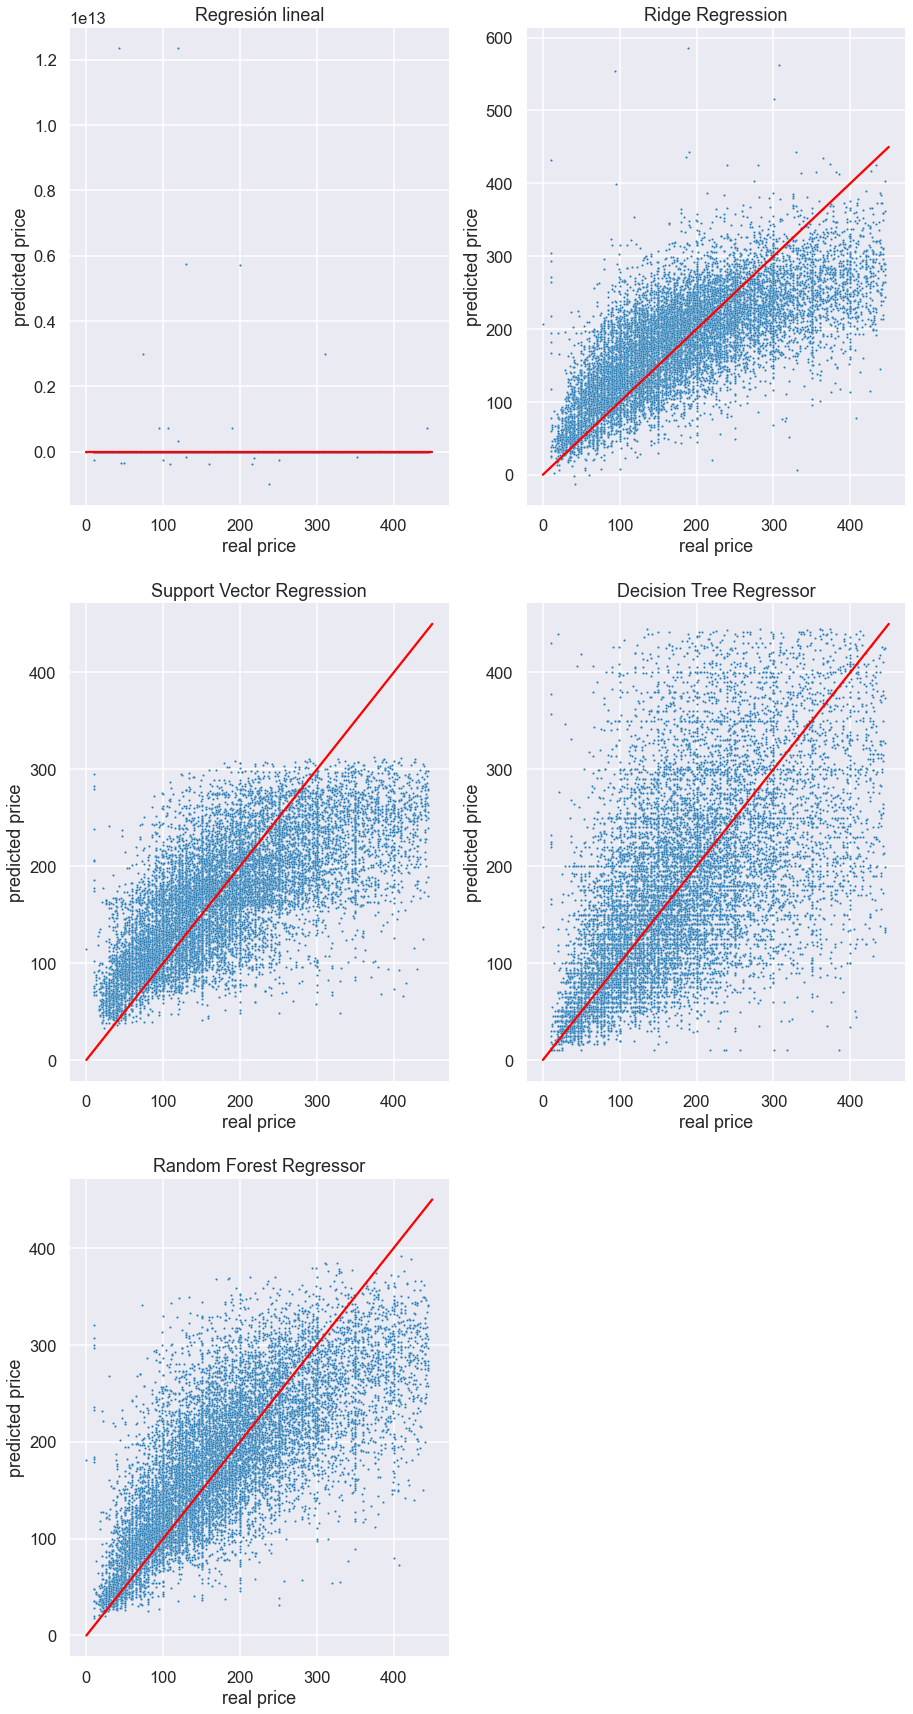

In [101]:
x = np.linspace(0, 450, 10)
models = train_results.iloc[:,0]
predictions = [LinR_t, rr_t, svr_t, dtr_t, rfr_t]
    
fig = plt.figure(figsize=(15,30))
c = 1
for m, p in zip(models, predictions):
    plt.subplot(3, 2, c)
    plt.title('{}'.format(m, 3, 2, c))
    plt.xlabel("real price")
    plt.ylabel("predicted price")
    plt.plot(x, x + 0, '-r')
    sns.scatterplot(x=y_train, y=p, s=5)
    c = c + 1

plt.show()

Destacar tal como se puede ver tanto en los resultados como la regresión lineal no consigue ofrecer unos resultados coherentes debido al número de variables utilizadas. Por otro lado, el error medio de los modelos es cercano a 50, algunos inferior y otros superior.

## Test de los modelos

In [102]:
test_results = []

In [104]:
LinR_pred = LinR.predict(X_test)
mse = MSE(y_test,LinR_pred)
rmse = RMSE(y_test,LinR_pred)
mae = MAE(y_test,LinR_pred)
r2 = r2_score(y_test, LinR_pred)
test_results.append(["Regresión lineal", mse, rmse, mae,r2])

In [105]:
rr_pred = rr.predict(X_test)
mse = MSE(y_test,rr_pred)
rmse = RMSE(y_test,rr_pred)
mae = MAE(y_test,rr_pred)
r2 = r2_score(y_test, rr_pred)
test_results.append(["Ridge Regression", mse, rmse, mae, r2])

In [106]:
svr_pred = svr.predict(X_test)
mse = MSE(y_test,svr_pred)
rmse = RMSE(y_test,svr_pred)
mae = MAE(y_test,svr_pred)
r2 = r2_score(y_test, svr_pred)
test_results.append(["Support Vector Regression", mse, rmse, mae, r2])

In [107]:
dtr_pred = dtr.predict(X_test)
mse = MSE(y_test,dtr_pred)
rmse = RMSE(y_test,dtr_pred)
mae = MAE(y_test,dtr_pred)
r2 = r2_score(y_test, dtr_pred)
test_results.append(["Decision Tree Regressor", mse, rmse, mae, r2])

In [108]:
rfr_pred = rfr.predict(X_test)
mse = MSE(y_test,rfr_pred)
rmse = RMSE(y_test,rfr_pred)
mae = MAE(y_test,rfr_pred)
r2 = r2_score(y_test, rfr_pred)
test_results.append(["Random Forest Regressor", mse, rmse, mae, r2])

## Discusión de los resultados de test y elección del mejor modelo

In [109]:
test_results = pd.DataFrame(test_results, columns=["Modelo", "MSE", "RMSE", "MAE", "R2"])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(test_results)

,Modelo,MSE,RMSE,MAE,R2
0,Regresión lineal,298803381602587508736.000,17285930163.072,613198483.763,-33974647934935628.000
1,Ridge Regression,4777.760,69.121,50.706,0.457
2,Support Vector Regression,4985.625,70.609,53.310,0.433
3,Decision Tree Regressor,7595.191,87.150,64.436,0.136
4,Random Forest Regressor,4220.688,64.967,48.636,0.520


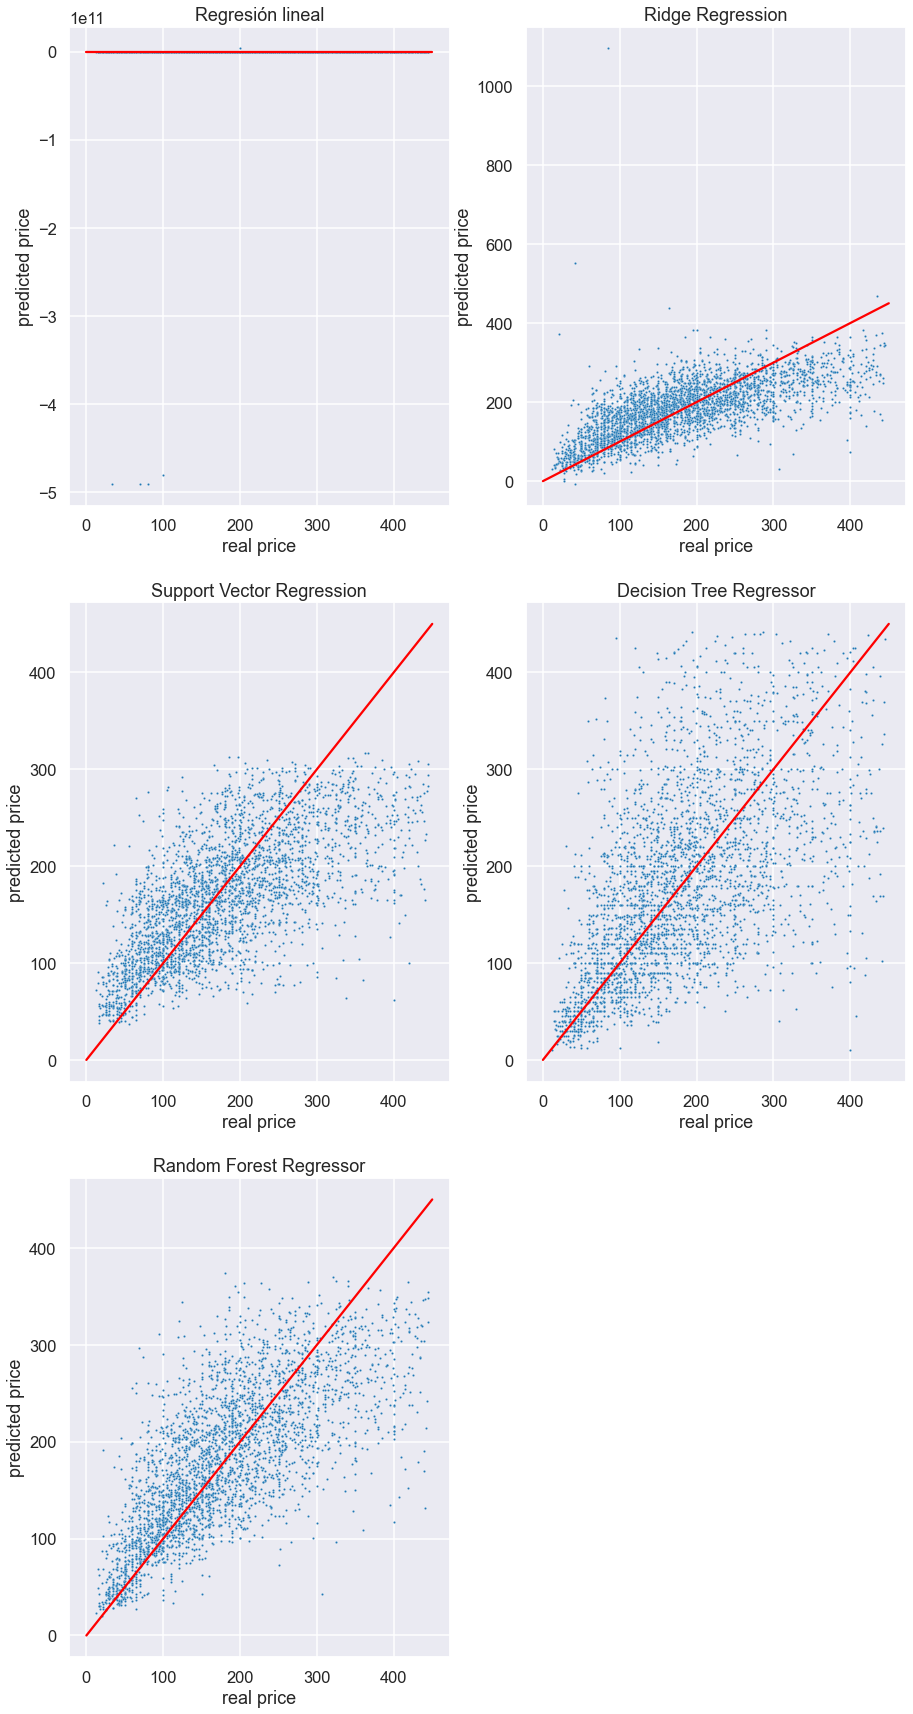

In [110]:
x = np.linspace(0, 450, 10)
models = test_results.iloc[:,0]
predictions = [LinR_pred, rr_pred, svr_pred, dtr_pred, rfr_pred]
    
fig = plt.figure(figsize=(15,30))
c = 1
for m, p in zip(models, predictions):
    plt.subplot(3, 2, c)
    plt.title('{}'.format(m, 3, 2, c))
    plt.xlabel("real price")
    plt.ylabel("predicted price")
    plt.plot(x, x + 0, '-r')
    sns.scatterplot(x=y_test, y=p, s=5)
    c = c + 1

plt.show()

Visualizando los resultados de test, y teniendo en cuenta los obtenidos en el entrenamiento, volver a incidir en los malos resultados de la regresión lineal. Por otro lado, destacar como no existe un underfitting ni overfitting excesivo ya que los resultados obtenidos tanto en el entrenamiento como en el test son muy parejos. Así pues, se pueden destacar dos modelos, el Random Forest y la Ridge Regression, siendo el Random Forest el mejor modelo.

# PCA

Una vez conocidos los posibles resultados obtenidos con el dataset utilizado, valoraremos la opción de realizar un PCA para poder reducir la dimensionalidad y comparar con los resultados anteriores si dicha reducción puede ser beneficiosa.

A continuación, se puede ver en el siguiente gráfico cual es el número de componentes que nos permtite tener una varianza acumulada del 99% de la información.

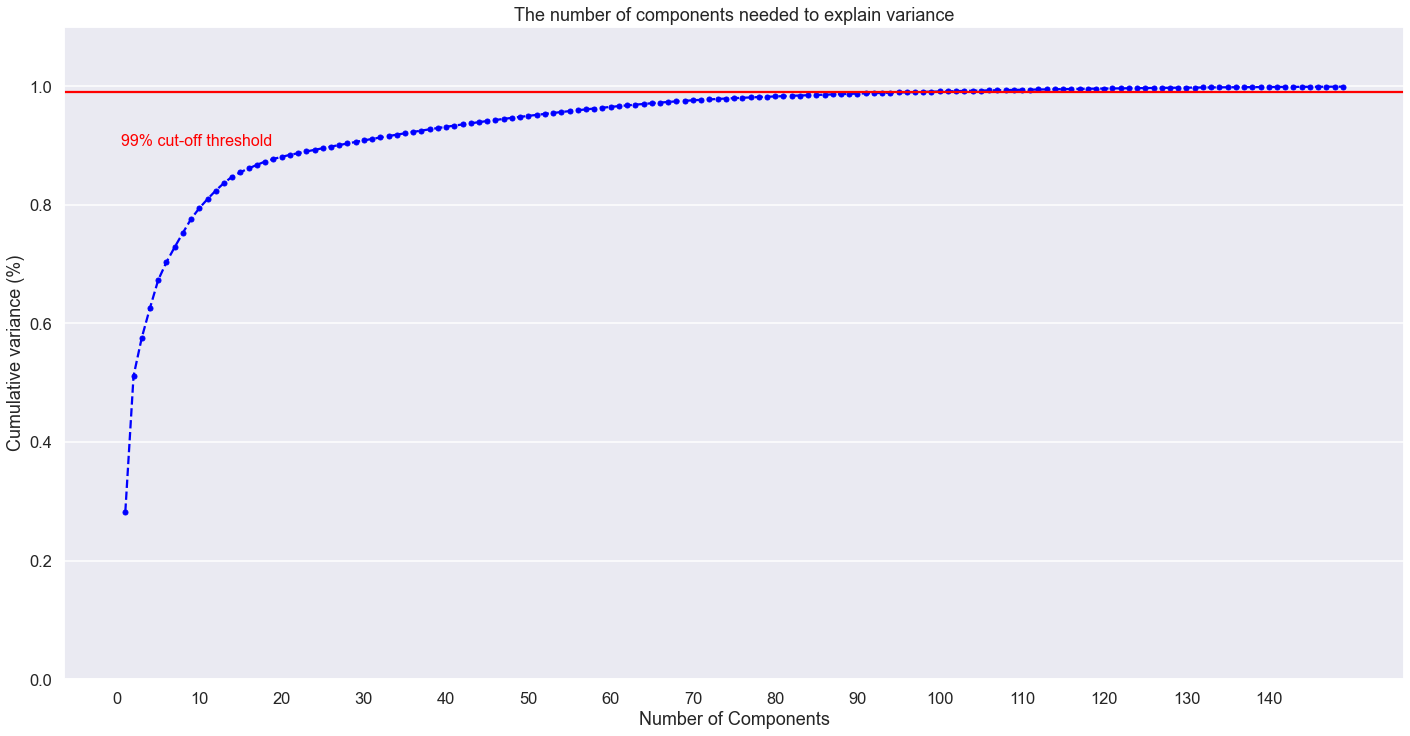

In [111]:
pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (24,12)

fig, ax = plt.subplots()
xi = np.arange(1, 150, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
y = y[0:149]

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b', markersize=5)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 150, step=10))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.9, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [112]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
print(len(pca.explained_variance_ratio_))

97


El número de componentes obtenido en el PCA es 97, permitiendo reducir de 205 variables a 97.

Y ahora, volveremos a analizar los modelos pero utilizando el dataset obtenido con la PCA.

In [114]:
train_results_pca = []

In [115]:
LinR = LinearRegression()
LinR_t = cross_val_predict(LinR, X_train_pca, y_train, cv=5)
mse = MSE(y_train,LinR_t)
rmse = RMSE(y_train,LinR_t)
mae = MAE(y_train,LinR_t)
r2 = r2_score(y_train, LinR_t)
train_results_pca.append(["Regresión lineal",mse, rmse, mae, r2])
LinR.fit(X_train_pca, y_train)

LinearRegression()

In [116]:
rr = Ridge()
rr_t = cross_val_predict(rr, X_train_pca, y_train, cv=5)
mse = MSE(y_train,rr_t)
rmse = RMSE(y_train,rr_t)
mae = MAE(y_train,rr_t)
r2 = r2_score(y_train, rr_t)
train_results_pca.append(["Ridge Regression",mse, rmse, mae, r2])
rr.fit(X_train_pca, y_train)

Ridge()

In [117]:
svr = SVR()
svr_t = cross_val_predict(svr, X_train_pca, y_train, cv=5)
mse = MSE(y_train,svr_t)
rmse = RMSE(y_train,svr_t)
mae = MAE(y_train,svr_t)
r2 = r2_score(y_train, svr_t)
train_results_pca.append(["Support Vector Regression", mse, rmse, mae, r2])
svr.fit(X_train_pca, y_train)

SVR()

In [118]:
dtr = DecisionTreeRegressor()
dtr_t = cross_val_predict(dtr, X_train_pca, y_train, cv=5)
mse = MSE(y_train,dtr_t)
rmse = RMSE(y_train,dtr_t)
mae = MAE(y_train,dtr_t)
r2 = r2_score(y_train, dtr_t)
train_results_pca.append(["Decision Tree Regressor", mse, rmse, mae, r2])
dtr.fit(X_train_pca, y_train)

DecisionTreeRegressor()

In [119]:
rfr = RandomForestRegressor()
rfr_t = cross_val_predict(rfr, X_train_pca, y_train, cv=5)
mse = MSE(y_train,rfr_t)
rmse = RMSE(y_train,rfr_t)
mae = MAE(y_train,rfr_t)
r2 = r2_score(y_train, rfr_t)
train_results_pca.append(["Random Forest Regressor", mse, rmse, mae, r2])
rfr.fit(X_train_pca, y_train)

RandomForestRegressor()

In [121]:
train_results_pca = pd.DataFrame(train_results_pca, columns=["Modelo", "MSE", "RSME", "MAE", "R2"])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_results_pca.head()

,Modelo,MSE,RSME,MAE,R2
0,Regresión lineal,4576.590,67.650,51.647,0.512
1,Ridge Regression,4576.110,67.647,51.644,0.512
2,Support Vector Regression,5111.430,71.494,53.981,0.455
3,Decision Tree Regressor,8796.717,93.791,69.477,0.061
4,Random Forest Regressor,4345.268,65.919,49.835,0.536


In [122]:
X_test_pca = pca.transform(X_test)

In [123]:
test_results_pca = []

In [124]:
LinR_pred = LinR.predict(X_test_pca)
mse = MSE(y_test,LinR_pred)
rmse = RMSE(y_test,LinR_pred)
mae = MAE(y_test,LinR_pred)
r2 = r2_score(y_test, LinR_pred)
test_results_pca.append(["Regresión lineal", mse, rmse, mae, r2])

In [125]:
rr_pred = rr.predict(X_test_pca)
mse = MSE(y_test,rr_pred)
rmse = RMSE(y_test,rr_pred)
mae = MAE(y_test,rr_pred)
r2 = r2_score(y_test, rr_pred)
test_results_pca.append(["Ridge Regression", mse, rmse, mae, r2])

In [126]:
svr_pred = svr.predict(X_test_pca)
mse = MSE(y_test,svr_pred)
rmse = RMSE(y_test,svr_pred)
mae = MAE(y_test,svr_pred)
r2 = r2_score(y_test, svr_pred)
test_results_pca.append(["Support Vector Regression", mse, rmse, mae, r2])

In [127]:
dtr_pred = dtr.predict(X_test_pca)
mse = MSE(y_test,dtr_pred)
rmse = RMSE(y_test,dtr_pred)
mae = MAE(y_test,dtr_pred)
r2 = r2_score(y_test, dtr_pred)
test_results_pca.append(["Decision Tree Regressor", mse, rmse, mae, r2])

In [128]:
rfr_pred = rfr.predict(X_test_pca)
mse = MSE(y_test,rfr_pred)
rmse = RMSE(y_test,rfr_pred)
mae = MAE(y_test,rfr_pred)
r2 = r2_score(y_test, rfr_pred)
test_results_pca.append(["Random Forest Regressor", mse, rmse, mae, r2])

In [129]:
test_results_pca = pd.DataFrame(test_results_pca, columns=["Modelo", "MSE", "RMSE", "MAE", "R2"])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(test_results_pca)

,Modelo,MSE,RMSE,MAE,R2
0,Regresión lineal,4838.376,69.558,51.391,0.450
1,Ridge Regression,4838.250,69.558,51.388,0.450
2,Support Vector Regression,5002.621,70.729,53.414,0.431
3,Decision Tree Regressor,8439.548,91.867,67.821,0.040
4,Random Forest Regressor,4212.067,64.900,49.244,0.521


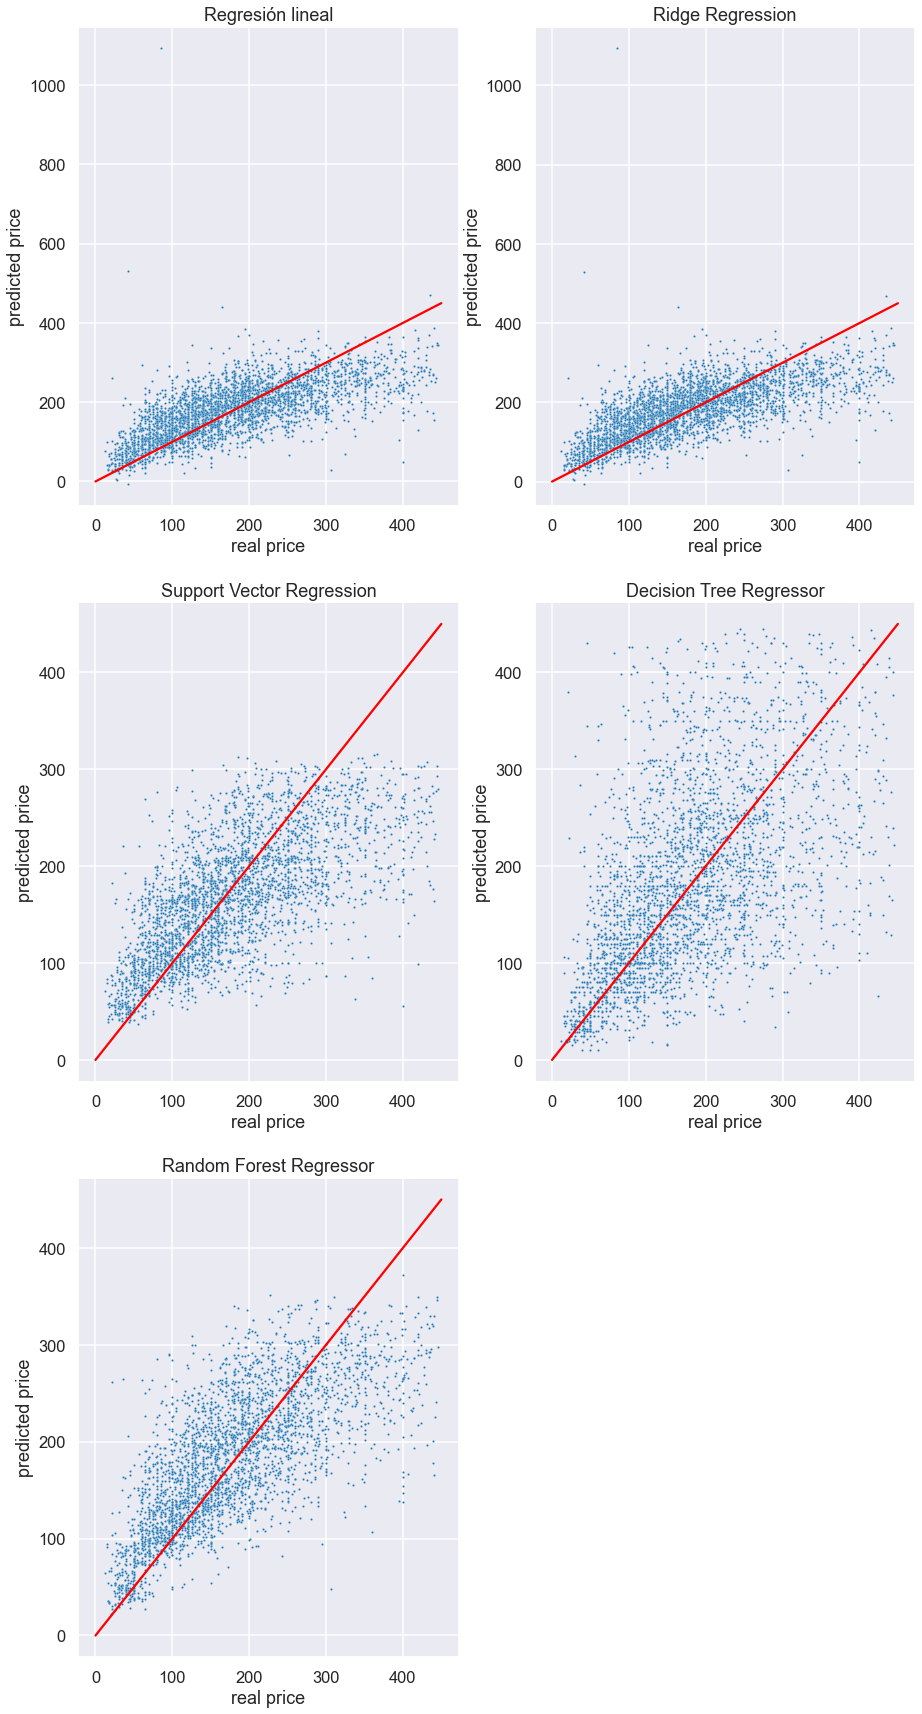

In [131]:
x = np.linspace(0, 450, 10)
models = test_results.iloc[:,0]
predictions = [LinR_pred, rr_pred, svr_pred, dtr_pred, rfr_pred]
    
fig = plt.figure(figsize=(15,30))
c = 1
for m, p in zip(models, predictions):
    plt.subplot(3, 2, c)
    plt.title('{}'.format(m, 3, 2, c))
    plt.xlabel("real price")
    plt.ylabel("predicted price")
    plt.plot(x, x + 0, '-r')
    sns.scatterplot(x=y_test, y=p, s=5)
    c = c + 1

plt.show()

A nivel general, destacar que la reducción de dimensionalidad mediante PCA no permite obtener unos mejores resultados siendo levemente peores, sin embargo, si se está dispuesto a incrementar levemente el error, la reducción de dimensionalidad nos permitiría reducir en más de la mitad el número de variables y consigo el tiempo de entrenamiento. Por otro lado, destacar que la utilización del PCA si ha permitido que la regresión lineal funcione correctamente, a diferencia de los que se ha podido ver con el dataset completo, obteniendo unos resultados practicamente iguales a los del Ridge regression.

# Ajuste de los hiperparámetros del mejor modelo

Se realizará un hyper-parameter tunning para obtener aquellos parámetros para el modelo Random Forest, que ha sido el mejor de los cinco, que mejores resultados obtenga. Para ello, se utilizará el método Grid Search.

In [132]:
parameters = {'max_depth': range(1, 20),
             'n_estimators': [100, 200, 300, 400]}
rfr = RandomForestRegressor()
clf = GridSearchCV(estimator=rfr, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 20),
                         'n_estimators': [100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [133]:
best_params = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(abs(clf.cv_results_["mean_test_score"]), columns=["MSE"])],axis=1)
best_params

,max_depth,n_estimators,MSE
0,1,100,6261.504
1,1,200,6255.654
2,1,300,6264.710
3,1,400,6260.613
4,2,100,5318.968
5,2,200,5312.105
6,2,300,5313.636
7,2,400,5312.126
8,3,100,4866.995
9,3,200,4856.958


In [134]:
clf.best_params_

{'max_depth': 16, 'n_estimators': 300}

In [135]:
best_model_pred = clf.predict(X_test)
mse = MSE(y_test,best_model_pred)
rmse = RMSE(y_test,best_model_pred)
mae = MAE(y_test,best_model_pred)
r2 = r2_score(y_test,best_model_pred)
print("MSE:", mse, "RMSE", rmse,"MAE", mae, "R2", r2)

MSE: 4044.193259348782 RMSE 63.59397187901367 MAE 47.70662464923701 R2 0.5401657055208345


Finalmente, el Random Forest con parámetros max_depth=16 y n_estimators=300 ha permitido mejorar, aunque no de una forma muy significativa, los resultados del modelo con los parámetros por defecto siendo el que mejor resulados nos ha permitido obtener.

# Conclusión

En este trabajo se puede observar como se han llevado a cabo varios tratamientos y procedimientos a la hora de trabajar con un dataset real y poder solventar un problema que se nos ofrece. Para ello, ha sido necesario un análisis del dataset obtenido y cargado para poder entender cada una de sus características y conocer si tienen relación con el precio, que es objetivo el cual se quiere predecir. Una vez realizado dicho análisis se ha escogido las características con relación, eliminando el resto de características no importantes, y se ha realizado una limpieza de estas convirtiendo las características categóricas o en formato string a valor númericos mediante diferentes procesos como lambdas o One Hot Encodings. Seguidamente, ha sido necesario el completar aquellos valores del dataset que tenian un valor nulo y, posteriormente, se ha normalizado y estandarizado el dataset. 
Una vez obtenido el dataset sobre el que trabajar, se ha divido en dos grupos, entrenamiento y test, para poder evaluar los cinco modelos seleccionados mediantes las cuatro métricas selecciondas. Para ello se ha realizado un entrenamiento mediante k-fold cross validation y posteriormente el test de estos con unas muestras nuevas, que el modelo no conocía. Una vez obtenido los resultados, se ha realizado un PCA con la intención de comparar si una reducción del número de variables del dataset permitiría mejorar los resultados, observando que no mejoraba los resultados pero si se estaba dispuesto a aumentar levemente el error se podía obtener un tiempos de ejecución menores. Finalmente, se elegió el mejor modelo, el Random Forest Regressor y se realizado un ajuste de los hiperparámetros para obtener aquellos que son más adecuados siendo este el resultado proporcionado para resolver el problema.